In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import logging
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Optional

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from classification import Pipeline

RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
No module named 'keras.__internal__'

In [ ]:
pipeline = Pipeline(similarity=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = pipeline.load_dataset_from_file()
input_shape = X_train.shape[1]

In [ ]:
input_shape

795

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_shape, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2)
])

In [ ]:
from tensorflow.python.training.saver import metrics
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [ ]:
NUM_EPOCHS = 150

history = model.fit(
      x = X_train,
      y = y_train,
      epochs = NUM_EPOCHS,
      batch_size=16,
      verbose = 1,
      validation_data=(X_valid, y_valid))

Epoch 1/150
4/4 [==============================] - 2s 60ms/step - loss: 3.8912 - accuracy: 0.5088 - val_loss: 0.4126 - val_accuracy: 0.8000
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 3.3119 - accuracy: 0.5088 - val_loss: 0.5226 - val_accuracy: 0.7000
Epoch 3/150
4/4 [==============================] - 0s 13ms/step - loss: 2.4541 - accuracy: 0.7018 - val_loss: 0.5571 - val_accuracy: 0.7500
Epoch 4/150
4/4 [==============================] - 0s 11ms/step - loss: 2.6494 - accuracy: 0.7368 - val_loss: 0.5586 - val_accuracy: 0.7500
Epoch 5/150
4/4 [==============================] - 0s 13ms/step - loss: 2.6838 - accuracy: 0.7018 - val_loss: 0.6149 - val_accuracy: 0.7000
Epoch 6/150
4/4 [==============================] - 0s 12ms/step - loss: 2.6618 - accuracy: 0.7193 - val_loss: 0.6415 - val_accuracy: 0.7000
Epoch 7/150
4/4 [==============================] - 0s 13ms/step - loss: 3.4838 - accuracy: 0.6842 - val_loss: 0.6504 - val_accuracy: 0.7500
Epoch 8/150
4/4 [===

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 19ms/step - loss: 1.0186 - accuracy: 0.7500


[1.0185927152633667, 0.75]

In [ ]:
predictions = []
for value in (model.predict(X_test)>=0.5).astype(int):
  predictions.append(value[0])
predictions = np.array(predictions)
actual = y_test

print(predictions)
print(actual)

1/1 [==============================] - 0s 75ms/step
[0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0]
[1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0]


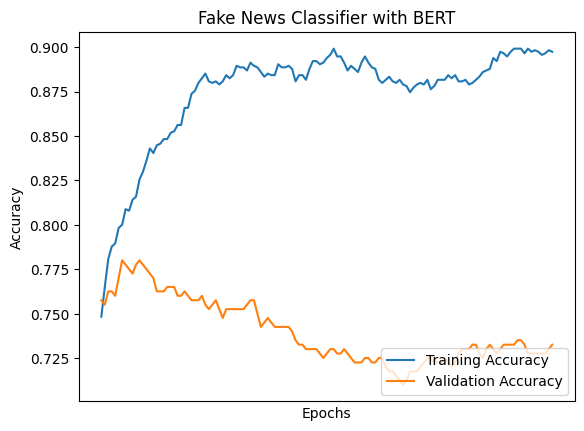

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

AVERAGING = 20

train_accs = history.history['accuracy']
train_graph = moving_average(train_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(train_graph))]

validation_accs = history.history['val_accuracy']
val_graph = moving_average(validation_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(val_graph))]

plt.plot(np.asarray(epoch_range).astype(str), train_graph, label='Training Accuracy')
plt.plot(np.asarray(epoch_range).astype(str), val_graph, label='Validation Accuracy')
plt.xticks([])
plt.title('Fake News Classifier with BERT')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# validation accuracy, recall, precision, F1-score
predictions = []
for value in (model.predict(X_test)>=0.5).astype(int):
  predictions.append(value[0])
predictions = np.array(predictions)
actual = y_test


from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(f1_score(actual, predictions))
print(classification_report(actual, predictions))

1/1 [==============================] - 0s 15ms/step
0.7368421052631579
              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.88      0.64      0.74        11

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



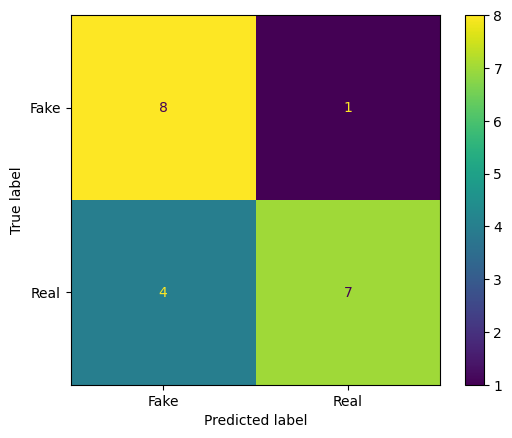

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actual, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot()
plt.show()

In [ ]:
#model.save("fake_news_classification_model")